<a href="https://colab.research.google.com/github/Sergikavtaradze/SAM3D_text/blob/main/3DSAM_Text_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3DSAM_Text Result Visualization

This notebook loads a 3D SAM-based model, runs inference on test cases with a text prompt, and visualizes predictions with overlays. Update paths in the **Configuration** cell before running.

In [ ]:
# Download the code
!git clone https://github.com/Sergikavtaradze/SAM3D_text.git

# Sample Dataset from the paper https://www.nature.com/articles/s41597-024-04218-8?utm
# Dataset website - https://springernature.figshare.com/articles/dataset/Mapping_pituitary_neuroendocrine_tumors_an_annotated_MRI_dataset_profiling_tumor_and_carotid_characteristics/27894084

# We have randomly sampled 5 MRI's from the dataset as it is 44GB.
!gdown 1kgKjt0NyqMkUOtGFsCHTVPtoyaYIL-FY
!unzip Sample_Dataset.zip

# SAM checkpoint
# !gdown 1i7kT975FGLsqL10bCkNmfCZxXVG1EbH7

Cloning into 'SAM3D_text'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 89 (delta 30), reused 75 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 85.17 KiB | 4.73 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Downloading...
From (original): https://drive.google.com/uc?id=1kgKjt0NyqMkUOtGFsCHTVPtoyaYIL-FY
From (redirected): https://drive.google.com/uc?id=1kgKjt0NyqMkUOtGFsCHTVPtoyaYIL-FY&confirm=t&uuid=173191e8-6590-4047-878a-2b1b54ff02e6
To: /content/Sample_Dataset.zip
100% 1.28G/1.28G [00:15<00:00, 83.7MB/s]
Archive:  Sample_Dataset.zip
   creating: Sample_Dataset/
  inflating: Sample_Dataset/29_carotids_f.nii.gz  
  inflating: __MACOSX/Sample_Dataset/._29_carotids_f.nii.gz  
  inflating: Sample_Dataset/6_tumor_f.nii.gz  
  inflating: __MACOSX/Sample_Dataset/._6_tumor_f.nii.gz  
  inflating: Sample_Dataset/56_carotids_f.nii.gz  
  inflating: __MACOSX/Sample_

## Checkpoints

Below are checkpoints for the prompt encoder. Only import the one you are testing for memory.


### Point Prompt Checkpoints

In [ ]:
# 128 crop

In [ ]:
# 192 crop

### LLAMA Checkpoints

**Choose only one per colab runtime session**

In [ ]:
# LLAMA Checkpoints

# 128 crop
!gdown 1vSJCZTgqEQ0ecs85s5ROlSi2CFmhVnT3

# 192 crop


Downloading...
From (original): https://drive.google.com/uc?id=1vSJCZTgqEQ0ecs85s5ROlSi2CFmhVnT3
From (redirected): https://drive.google.com/uc?id=1vSJCZTgqEQ0ecs85s5ROlSi2CFmhVnT3&confirm=t&uuid=4cc3da7b-bf8b-48db-bcc8-55154dac8edf
To: /content/best.pth.tar
100% 5.98G/5.98G [01:31<00:00, 65.7MB/s]


### GPT Checkpoints

**Choose only one per colab runtime session**

In [ ]:
# GPT Checkpoints

# 128 crop
!gdown 1OhOkuMwqCq3f13F3y5iAilOPMBIlvUUe

Downloading...
From (original): https://drive.google.com/uc?id=1OhOkuMwqCq3f13F3y5iAilOPMBIlvUUe
From (redirected): https://drive.google.com/uc?id=1OhOkuMwqCq3f13F3y5iAilOPMBIlvUUe&confirm=t&uuid=05d21f28-5d72-43d7-8815-b2fc8dbfe481
To: /content/best.pth.tar
100% 3.03G/3.03G [00:52<00:00, 57.5MB/s]


In [ ]:
# GPT Checkpoints (If you ran above cell dont run this)
# 192 crop
!gdown 1lPIJPOGxAgm7-V8S0wkxDTPKib-cf6hn

Downloading...
From (original): https://drive.google.com/uc?id=1lPIJPOGxAgm7-V8S0wkxDTPKib-cf6hn
From (redirected): https://drive.google.com/uc?id=1lPIJPOGxAgm7-V8S0wkxDTPKib-cf6hn&confirm=t&uuid=3df1270b-6f59-498e-b619-971299806e6f
To: /content/best.pth.tar
100% 3.03G/3.03G [00:53<00:00, 57.1MB/s]


#### Install necessary packages

In [ ]:
!pip install -U monai>=1.4.0
!pip install -q nibabel surface-distance transformers matplotlib torch numpy

In [ ]:
%cd /content/SAM3D_text

# All imports at the top
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from functools import partial

# Medical imaging libraries
from monai.losses import DiceLoss
import surface_distance
from surface_distance import metrics
import nibabel as nib

# Custom modules
from dataset.datasets import load_data_volume_maskwise
from modeling.image_encoder import ImageEncoderViT_3d_v2 as ImageEncoderViT_3d
from modeling.mask_decoder import VIT_MLAHead_h as VIT_MLAHead
from modeling.prompt_encoder import PromptEncoder, PromptEncoder_Text_Llama, PromptEncoder_Text
from transformers import GPT2Tokenizer
import warnings
warnings.filterwarnings("ignore")

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

/content/SAM3D_text


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
def seed_everything(seed=24):
    random.seed(seed)

In [ ]:
def load_model(snapshot_path, device, model_type):
    """Load the 3DSAM model components"""
    checkpoint_file = "best.pth.tar"
    checkpoint_path = os.path.join(snapshot_path, checkpoint_file)

    print(f"Loading checkpoint: {checkpoint_path}")

    # Load image encoder
    img_encoder = ImageEncoderViT_3d(
        depth=12, embed_dim=768, img_size=1024, mlp_ratio=4,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
        num_heads=12, patch_size=16, qkv_bias=True, use_rel_pos=True,
        global_attn_indexes=[2, 5, 8, 11], window_size=14,
        cubic_window_size=8, out_chans=256, num_slice=16
    )

    state = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    img_encoder.load_state_dict(state["encoder_dict"], strict=True)
    img_encoder.to(device)
    img_encoder.eval()

    # Load prompt encoder
    if model_type == "gpt":
        prompt_encoder = PromptEncoder_Text().to(device)
    elif model_type == "llama":
        prompt_encoder = PromptEncoder_Text_Llama().to(device)
    elif model_type == 'point':
        prompt_encoder = PromptEncoder().to(device)
    else:
        raise ValueError(f"Invalid model type: {model_type}")
    feature_dict = state["feature_dict"]
    state_dict = feature_dict[3] if isinstance(feature_dict, list) else feature_dict
    prompt_encoder.load_state_dict(state_dict, strict=True)
    prompt_encoder.eval()

    # Load mask decoder
    mask_decoder = VIT_MLAHead(img_size=96, num_classes=2).to(device)
    mask_decoder.load_state_dict(state["decoder_dict"], strict=True)
    mask_decoder.to(device)
    mask_decoder.eval()

    return img_encoder, prompt_encoder, mask_decoder

In [ ]:
def model_predict(img, img_encoder, mask_decoder, prompt_encoder_text, target_class, patch_size, device):
    """Perform model prediction with text prompts"""

    # Determine text prompt
    prompt_text = "Segment the Pituitary Tumor" if target_class == "tumor" else "Segment the Internal Carotid Artery"

    # Process image
    out = F.interpolate(img.float(), scale_factor=512 / patch_size, mode='trilinear')
    input_batch = out[0].transpose(0, 1)
    batch_features, feature_list = img_encoder(input_batch)
    feature_list.append(batch_features)

    # Apply text prompt to appropriate feature layer
    new_feature = []
    for i, feature in enumerate(feature_list):
        if i == 3:
            text_features = prompt_encoder_text(feature, prompt_text)
            new_feature.append(text_features)
        else:
            new_feature.append(feature.to(device))

    # Add resized image
    img_resize = F.interpolate(
        img[0, 0].permute(1, 2, 0).unsqueeze(0).unsqueeze(0).to(device),
        scale_factor=64/patch_size, mode="trilinear"
    )
    new_feature.append(img_resize)

    # Generate masks
    masks = mask_decoder(new_feature, 2, patch_size//64)
    masks = masks.permute(0, 1, 4, 2, 3)

    return masks

In [ ]:
def perform_inference(img, seg, spacing, img_encoder, mask_decoder, prompt_encoder_text,
                     target_class, patch_size, num_prompts, tolerance, device):
    """Perform inference on a single case"""

    # Prepare segmentation
    seg = seg[:, 1, :, :, :].float()
    prompt = F.interpolate(seg[None, :, :, :, :], img.shape[2:], mode="nearest")[0]
    seg = seg.to(device).unsqueeze(0)
    img = img.to(device)

    # Sample prompt points
    seg_pred = torch.zeros_like(prompt).to(device)
    l = len(torch.where(prompt == 1)[0])
    if l > 0:
        sample = np.random.choice(np.arange(l), num_prompts, replace=True)
        x = torch.where(prompt == 1)[1][sample].unsqueeze(1)
        y = torch.where(prompt == 1)[3][sample].unsqueeze(1)
        z = torch.where(prompt == 1)[2][sample].unsqueeze(1)

        # Calculate crop center
        x_m = (torch.max(x) + torch.min(x)) // 2
        y_m = (torch.max(y) + torch.min(y)) // 2
        z_m = (torch.max(z) + torch.min(z)) // 2

        # Calculate crop boundaries
        d_min, d_max = x_m - patch_size//2, x_m + patch_size//2
        h_min, h_max = z_m - patch_size//2, z_m + patch_size//2
        w_min, w_max = y_m - patch_size//2, y_m + patch_size//2

        # Handle boundary conditions
        d_l, d_r = max(0, -d_min), max(0, d_max - prompt.shape[1])
        h_l, h_r = max(0, -h_min), max(0, h_max - prompt.shape[2])
        w_l, w_r = max(0, -w_min), max(0, w_max - prompt.shape[3])

        d_min, h_min, w_min = max(0, d_min), max(0, h_min), max(0, w_min)

        # Extract and pad patch
        img_patch = img[:, :, d_min:d_max, h_min:h_max, w_min:w_max].clone()
        img_patch = F.pad(img_patch, (w_l, w_r, h_l, h_r, d_l, d_r))

        # Run inference
        pred = model_predict(img_patch, img_encoder, mask_decoder, prompt_encoder_text,
                           target_class, patch_size, device)

        # Remove padding
        pred = pred[:, :, d_l:patch_size-d_r, h_l:patch_size-h_r, w_l:patch_size-w_r]
        pred = F.softmax(pred, dim=1)[:, 1]
        seg_pred[:, d_min:d_max, h_min:h_max, w_min:w_max] += pred

    # Resize to original dimensions
    final_pred = F.interpolate(seg_pred.unsqueeze(1), size=seg.shape[2:], mode="trilinear")
    masks = final_pred > 0.5

    # Calculate metrics
    dice_loss_fn = DiceLoss(include_background=False, softmax=False, to_onehot_y=True, reduction="none")
    loss = 1 - dice_loss_fn(masks, seg)
    dice_score = loss.item()

    # Calculate NSD
    ssd = surface_distance.compute_surface_distances(
        (seg == 1)[0, 0].cpu().numpy(),
        (masks == 1)[0, 0].cpu().numpy(),
        spacing_mm=spacing[0].numpy()
    )
    nsd = metrics.compute_surface_dice_at_tolerance(ssd, tolerance)

    return {
        'prediction': masks[0, 0].cpu().numpy(),
        'ground_truth': seg[0, 0].cpu().numpy(),
        'image': img[0, 0].cpu().numpy(),
        'dice_score': dice_score,
        'nsd': nsd,
        'spacing': spacing[0].numpy()
    }

In [ ]:
def plot_case(image, ground_truth, prediction, case_name, dice_score, nsd, save_path=None):
    """Plot 2D slices for a case with red overlays for both GT and Prediction"""

    # Find the slice with the most non-zero ground truth pixels
    slice_sums = np.sum(ground_truth > 0, axis=(1, 2))
    best_slice = np.argmax(slice_sums)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Base grayscale image for the slice
    base_img = image[best_slice]

    # Ground truth mask
    gt_mask = ground_truth[best_slice] > 0
    gt_overlay = np.zeros((*gt_mask.shape, 4))
    gt_overlay[gt_mask] = [1, 0, 0, 0.5]  # red with transparency

    # Prediction mask
    pred_mask = prediction[best_slice] > 0
    pred_overlay = np.zeros((*pred_mask.shape, 4))
    pred_overlay[pred_mask] = [1, 0, 0, 0.5]  # red with transparency

    # Original image
    axes[0].imshow(base_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground truth overlay
    axes[1].imshow(base_img, cmap='gray')
    axes[1].imshow(gt_overlay)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    # Prediction overlay
    axes[2].imshow(base_img, cmap='gray')
    axes[2].imshow(pred_overlay)
    axes[2].set_title('Prediction')
    axes[2].axis('off')

    plt.suptitle(f"{case_name} | Dice: {dice_score:.4f} | NSD: {nsd:.4f}")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()

## Configuration

Set the paths and parameters below.

In [ ]:
# Configuration - edit these paths as needed
snapshot_path = '/content'
data_prefix = "/content/Sample_Dataset"

num_cases = 3                                       # Number of test cases to process
rand_crop_size = (128, 128, 128)                    # Change if model being used has 192 crop !!!
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
print(f"Processing {num_cases} test cases")

Device: cuda
Processing 3 test cases


#### Inference Tumor

In [ ]:
target_class = "tumor"

seed_everything()

# Load model
# Choose model_type -> gpt, llama, point
img_encoder, prompt_encoder_text, mask_decoder = load_model(snapshot_path, device, model_type='gpt')

# Load test data
test_data = load_data_volume_maskwise(
    data="maskwise_endonasal",
    batch_size=1,
    path_prefix=data_prefix,
    pkl_filename="/content/SAM3D_text/datafile/split.pkl",
    augmentation=False,
    split="test",
    target_class=target_class,
    rand_crop_spatial_size=rand_crop_size,
    convert_to_sam=False,
    do_test_crop=False,
    deterministic=True,
    num_worker=0
)

print(f"Loaded {len(test_data)} test samples")

Loading checkpoint: /content/best.pth.tar


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

hidden_dim: 768
{'tumor': {0: {'test': {0: ['135_T1.nii.gz', '135_tumor_f.nii.gz'], 1: ['29_T1.nii.gz', '29_tumor_f.nii.gz'], 2: ['32_T1.nii.gz', '32_tumor_f.nii.gz'], 3: ['56_T1.nii.gz', '56_tumor_f.nii.gz'], 4: ['6_T1.nii.gz', '6_tumor_f.nii.gz']}}}, 'ica': {0: {'test': {0: ['135_T1.nii.gz', '135_carotids_f.nii.gz'], 1: ['29_T1.nii.gz', '29_carotids_f.nii.gz'], 2: ['32_T1.nii.gz', '32_carotids_f.nii.gz'], 3: ['56_T1.nii.gz', '56_carotids_f.nii.gz'], 4: ['6_T1.nii.gz', '6_carotids_f.nii.gz']}}}}
Loaded 5 test samples


Processing case 1/3
Dice: 0.5395 | NSD: 0.8011
Saved plot to: case_0_tumor_visualization.png


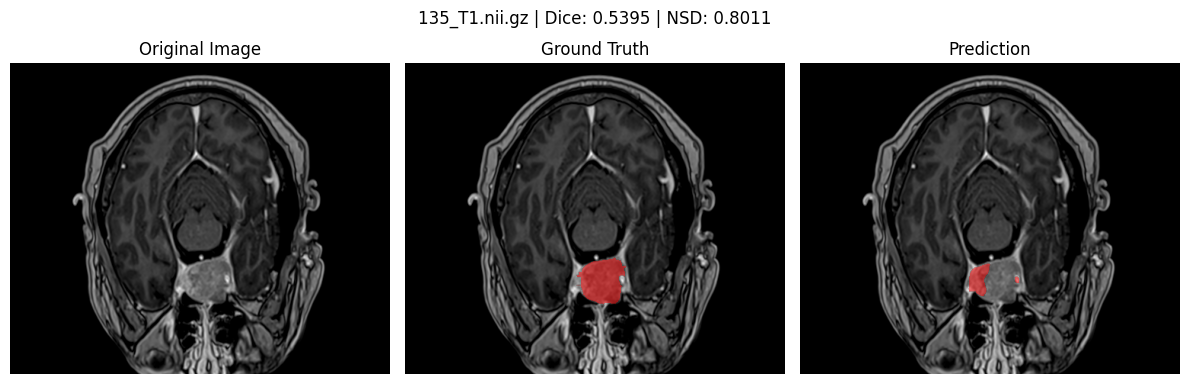

Processing case 2/3
Dice: 0.6253 | NSD: 0.8885
Saved plot to: case_1_tumor_visualization.png


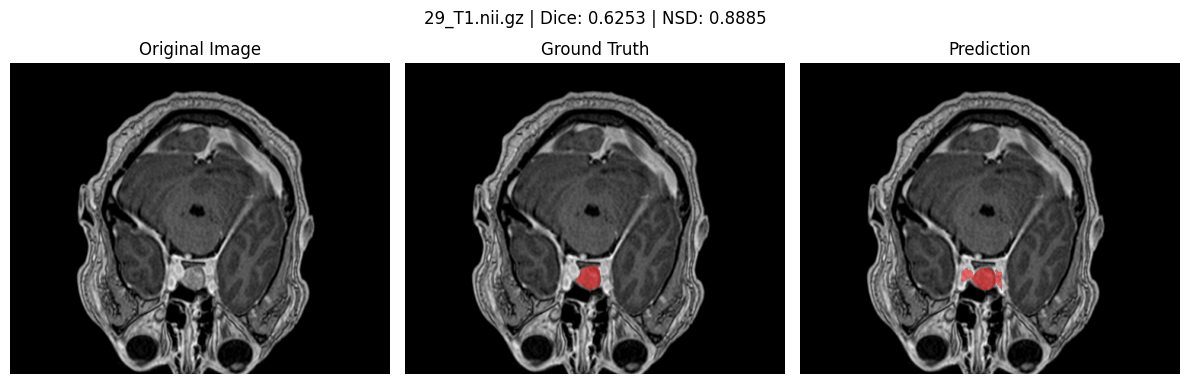

Processing case 3/3
Dice: 0.3237 | NSD: 0.7122
Saved plot to: case_2_tumor_visualization.png


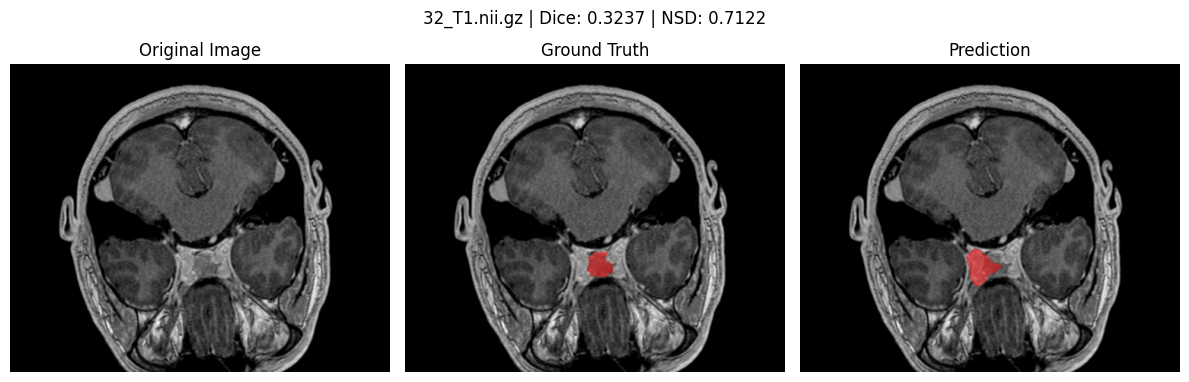

In [ ]:
results = []
with torch.no_grad():
    for idx, (img, seg, spacing, mask_type_idx) in enumerate(test_data):
        if idx >= num_cases:
            break

        print(f"Processing case {idx+1}/{min(num_cases, len(test_data.dataset))}")

        # Run inference
        result = perform_inference(
            img, seg, spacing, img_encoder, mask_decoder, prompt_encoder_text,
            target_class, rand_crop_size[0], 1, 5, device
        )

        # Add case info
        try:
            # Accessing the dataset attribute of the DataLoader
            result['case_name'] = test_data.dataset.img_dict[idx]
        except Exception:
            result['case_name'] = f"Case_{idx}"

        results.append(result)

        print(f"Dice: {result['dice_score']:.4f} | NSD: {result['nsd']:.4f}")

        # Plot results
        save_path = f"case_{idx}_{target_class}_visualization.png"
        plot_case(
            result['image'], result['ground_truth'], result['prediction'],
            result['case_name'], result['dice_score'], result['nsd'],
            save_path=save_path
        )

In [ ]:
# Summary statistics
if results:
    print("="*60)
    print("CASE-BY-CASE RESULTS")
    print("="*60)
    for result in results:
        print(f"Case: {result['case_name']} | Dice: {result['dice_score']:.4f} | NSD: {result['nsd']:.4f}")

    dice_scores = [r['dice_score'] for r in results]
    nsd_scores = [r['nsd'] for r in results]

    print("="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Cases processed: {len(results)}")
    print(f"Mean Dice: {np.mean(dice_scores):.4f}")
    print(f"Median Dice: {np.median(dice_scores):.4f}")
    print(f"Mean NSD: {np.mean(nsd_scores):.4f}")
    print(f"Median NSD: {np.median(nsd_scores):.4f}")
    print("="*60)

CASE-BY-CASE RESULTS
Case: 135_T1.nii.gz | Dice: 0.5395 | NSD: 0.8011
Case: 29_T1.nii.gz | Dice: 0.6253 | NSD: 0.8885
Case: 32_T1.nii.gz | Dice: 0.3237 | NSD: 0.7122
SUMMARY STATISTICS
Cases processed: 3
Mean Dice: 0.4962
Median Dice: 0.5395
Mean NSD: 0.8006
Median NSD: 0.8011


#### Inference ICA

In [ ]:
target_class = "ICA"

seed_everything()

# Load model
# Choose model_type -> gpt, llama, point
img_encoder, prompt_encoder_text, mask_decoder = load_model(snapshot_path, device, model_type='gpt')

# Load test data
test_data = load_data_volume_maskwise(
    data="maskwise_endonasal",
    batch_size=1,
    path_prefix=data_prefix,
    pkl_filename="/content/SAM3D_text/datafile/split.pkl",
    augmentation=False,
    split="test",
    target_class=target_class,
    rand_crop_spatial_size=rand_crop_size,
    convert_to_sam=False,
    do_test_crop=False,
    deterministic=True,
    num_worker=0
)

print(f"Loaded {len(test_data)} test samples")

Loading checkpoint: /content/best.pth.tar
hidden_dim: 768
{'tumor': {0: {'test': {0: ['135_T1.nii.gz', '135_tumor_f.nii.gz'], 1: ['29_T1.nii.gz', '29_tumor_f.nii.gz'], 2: ['32_T1.nii.gz', '32_tumor_f.nii.gz'], 3: ['56_T1.nii.gz', '56_tumor_f.nii.gz'], 4: ['6_T1.nii.gz', '6_tumor_f.nii.gz']}}}, 'ica': {0: {'test': {0: ['135_T1.nii.gz', '135_carotids_f.nii.gz'], 1: ['29_T1.nii.gz', '29_carotids_f.nii.gz'], 2: ['32_T1.nii.gz', '32_carotids_f.nii.gz'], 3: ['56_T1.nii.gz', '56_carotids_f.nii.gz'], 4: ['6_T1.nii.gz', '6_carotids_f.nii.gz']}}}}
Loaded 5 test samples


Processing case 1/3
Dice: 0.4916 | NSD: 0.9528
Saved plot to: case_0_ICA_visualization.png


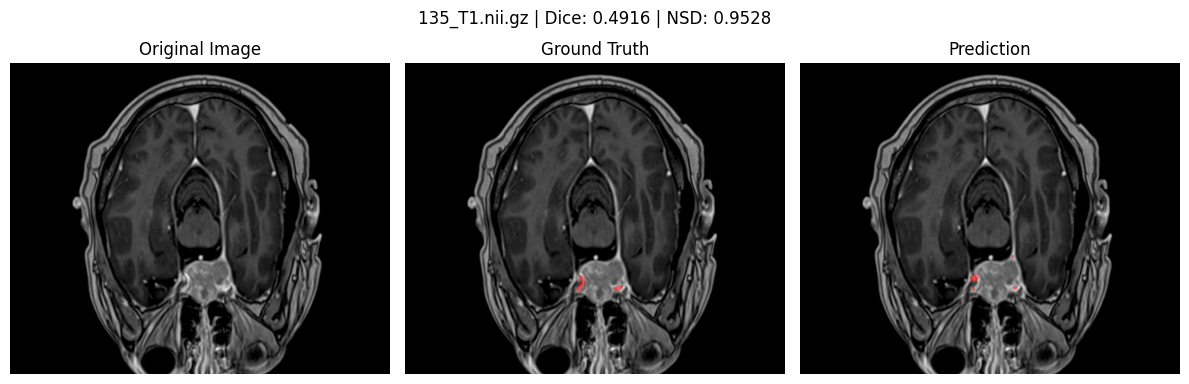

Processing case 2/3
Dice: 0.5465 | NSD: 0.8931
Saved plot to: case_1_ICA_visualization.png


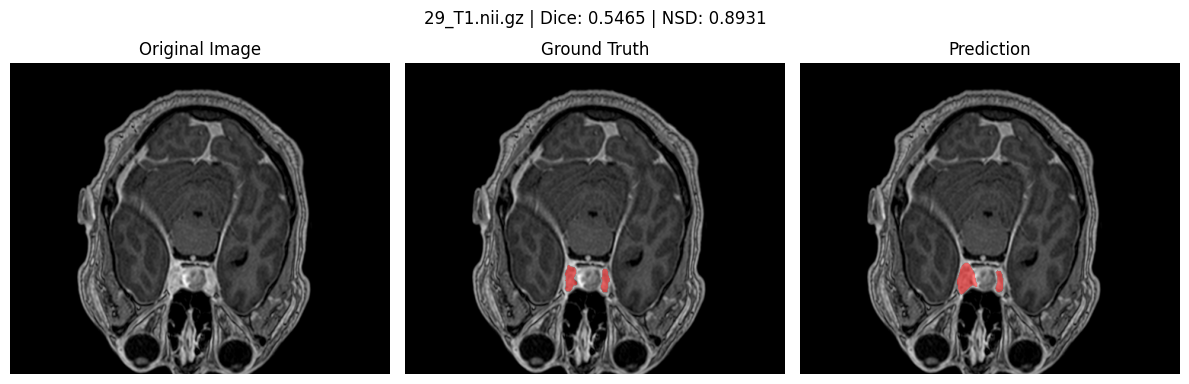

Processing case 3/3
Dice: 0.4412 | NSD: 0.8597
Saved plot to: case_2_ICA_visualization.png


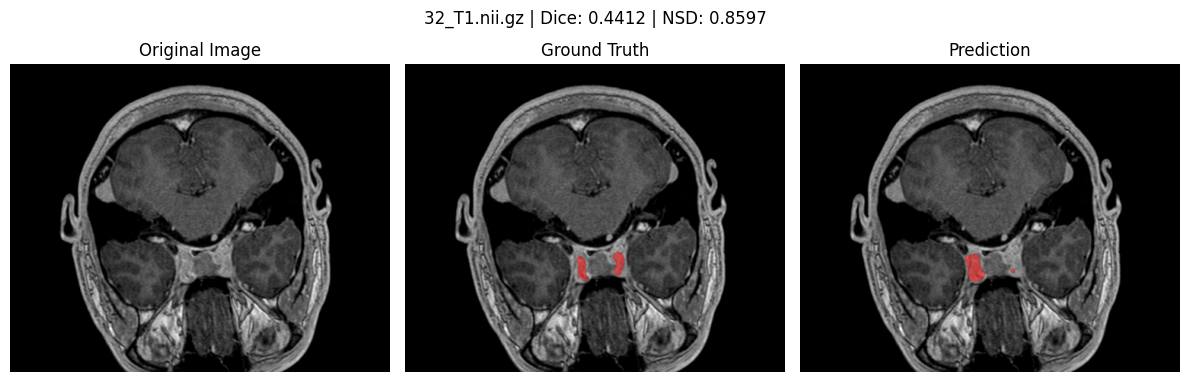

In [ ]:
results = []
with torch.no_grad():
    for idx, (img, seg, spacing, mask_type_idx) in enumerate(test_data):
        if idx >= num_cases:
            break

        print(f"Processing case {idx+1}/{min(num_cases, len(test_data.dataset))}")

        # Run inference
        result = perform_inference(
            img, seg, spacing, img_encoder, mask_decoder, prompt_encoder_text,
            target_class, rand_crop_size[0], 1, 5, device
        )

        # Add case info
        try:
            # Accessing the dataset attribute of the DataLoader
            result['case_name'] = test_data.dataset.img_dict[idx]
        except Exception:
            result['case_name'] = f"Case_{idx}"

        results.append(result)

        print(f"Dice: {result['dice_score']:.4f} | NSD: {result['nsd']:.4f}")

        # Plot results
        save_path = f"case_{idx}_{target_class}_visualization.png"
        plot_case(
            result['image'], result['ground_truth'], result['prediction'],
            result['case_name'], result['dice_score'], result['nsd'],
            save_path=save_path
        )

In [ ]:
# Summary statistics
if results:
    print("="*60)
    print("CASE-BY-CASE RESULTS")
    print("="*60)
    for result in results:
        print(f"Case: {result['case_name']} | Dice: {result['dice_score']:.4f} | NSD: {result['nsd']:.4f}")

    dice_scores = [r['dice_score'] for r in results]
    nsd_scores = [r['nsd'] for r in results]

    print("="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Cases processed: {len(results)}")
    print(f"Mean Dice: {np.mean(dice_scores):.4f}")
    print(f"Median Dice: {np.median(dice_scores):.4f}")
    print(f"Mean NSD: {np.mean(nsd_scores):.4f}")
    print(f"Median NSD: {np.median(nsd_scores):.4f}")
    print("="*60)

CASE-BY-CASE RESULTS
Case: 135_T1.nii.gz | Dice: 0.4916 | NSD: 0.9528
Case: 29_T1.nii.gz | Dice: 0.5465 | NSD: 0.8931
Case: 32_T1.nii.gz | Dice: 0.4412 | NSD: 0.8597
SUMMARY STATISTICS
Cases processed: 3
Mean Dice: 0.4931
Median Dice: 0.4916
Mean NSD: 0.9019
Median NSD: 0.8931
